Beginning of our project :)

Reading our Dataset Below:

In [2]:
#import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
import xgboost as xgb

from pprint import pprint

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline

#import imblearn
#from imblearn.over_sampling import SMOTE

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import mlflow
from mlflow import log_metric, log_param, log_artifacts

import joblib

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# DATA ANALYSIS STAGE

In [3]:
SEED = 12345
MB_dataset = pd.read_csv('mbti_1.csv')
print(MB_dataset)
MB_dataset.describe()
MB_dataset.isnull().sum()

      type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]


type     0
posts    0
dtype: int64

In [4]:
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
MB_dataset.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


<AxesSubplot: >

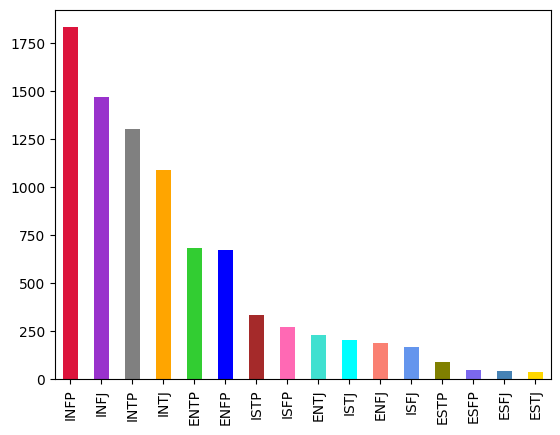

In [5]:
#make a bar chart of how often each personality type is mentioned in a post
MB_dataset["type"].value_counts()
colors = ['crimson', 'darkorchid', 'gray', 'orange', 'limegreen', 'blue', 'brown', 'hotpink', 'turquoise', 'cyan', 'salmon', 'cornflowerblue', 'olive', 'mediumslateblue', 'steelblue', 'gold']

MB_dataset["type"].value_counts().plot(kind="bar", color=['crimson', 'darkorchid', 'gray', 'orange', 'limegreen', 'blue', 'brown', 'hotpink', 'turquoise', 'cyan', 'salmon', 'cornflowerblue', 'olive', 'mediumslateblue', 'steelblue', 'gold' ])


# PREPROCESSING STAGE

In [6]:
lemmatiser = WordNetLemmatizer()
useless_words = nltk.corpus.stopwords.words('english')
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

In [ ]:
def replace_symbols(text):
    text = re.sub('https?\S+', ' ', text) #Removing urls 
    text = re.sub("[^a-zA-Z]", " ", text) #Removing non-words
    text = re.sub(' +', ' ', text) #Removing consecutive whitespace   
    pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
    pers_types = [p.lower() for p in pers_types]
    for t in pers_types:
        text = text.replace(t, "")
    p = re.compile("(" + "|".join(pers_types) + ")")
    text = " ".join([lemmatiser.lemmatize(w) for w in text.split(' ') if w not in useless_words])
    text = text.lower()
    return text

MB_dataset['cleaned_posts'] = MB_dataset['posts'].apply(replace_symbols)
MB_dataset.describe()
MB_dataset.head(10)


In [8]:
print("\nPost before preprocessing:\n\n", MB_dataset['posts'][0])



Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010

In [9]:
 print("\nPost after preprocessing:\n\n", MB_dataset['cleaned_posts'][0])



Post after preprocessing:

   moment sportscenter top ten play prank what life changing experience life on repeat today may perc experience immerse the last thing infj friend posted facebook committing suicide next day rest peace enfj sorry hear distress it natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg i mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left all thing moderation sims indeed video game good one note good one somewhat subjective i completely promoting death given sim dear enfp what favorite video game growing current favorite video game cool appears late sad there someone everyone wait i thought confidence good thing i cherish time solitude b c revel within inner world whereas time workin enjoy ti

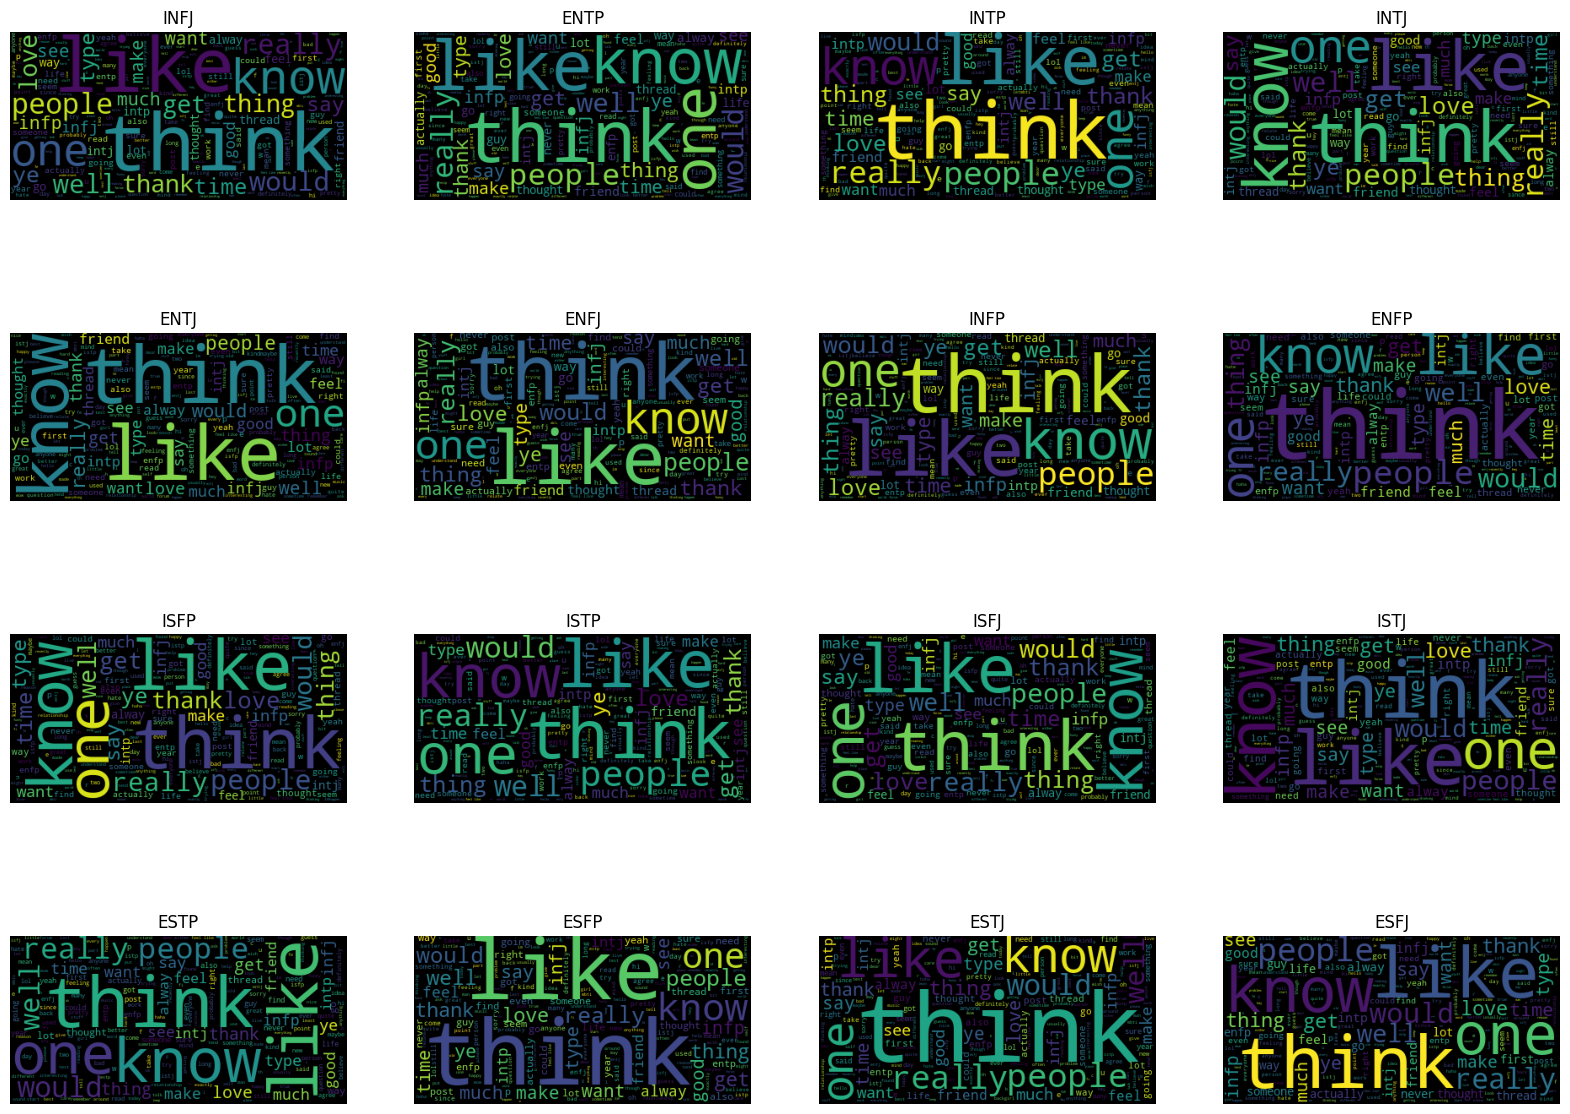

In [10]:
labels = MB_dataset['type'].unique()
row, col = 4, 4
wc = WordCloud(stopwords=useless_words)

fig, ax = plt.subplots(4, 4, figsize=(20,15))

for i in range(4):
    for j in range(4):
        cur_type = labels[i*col+j]
        cur_ax = ax[i][j]
        df = MB_dataset[MB_dataset['type'] == cur_type]
        wordcloud = wc.generate(MB_dataset['cleaned_posts'].to_string())
        cur_ax.imshow(wordcloud)
        cur_ax.axis('off')
        cur_ax.set_title(cur_type)

In [11]:
sw = MB_dataset.copy()

sw['words_per_comment'] = sw['cleaned_posts'].apply(lambda x: len(x.split())/50)
sw.head()

,type,posts,cleaned_posts,words_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank what ...,6.44
1,ENTP,'I'm finding the lack of me in these posts ver...,i finding lack post alarming sex boring posit...,14.10
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course i say i know blessing curse d...,10.14
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed conversation day esoteric...,12.46
4,ENTJ,'You're fired.|||That's another silly misconce...,you fired that another silly misconception th...,11.40


Classes are highly imbalanced. SMOTE() function failed to work because of some library incompability, stratified train_test splits and stratified K-fold validation is used to mitigate this setback.

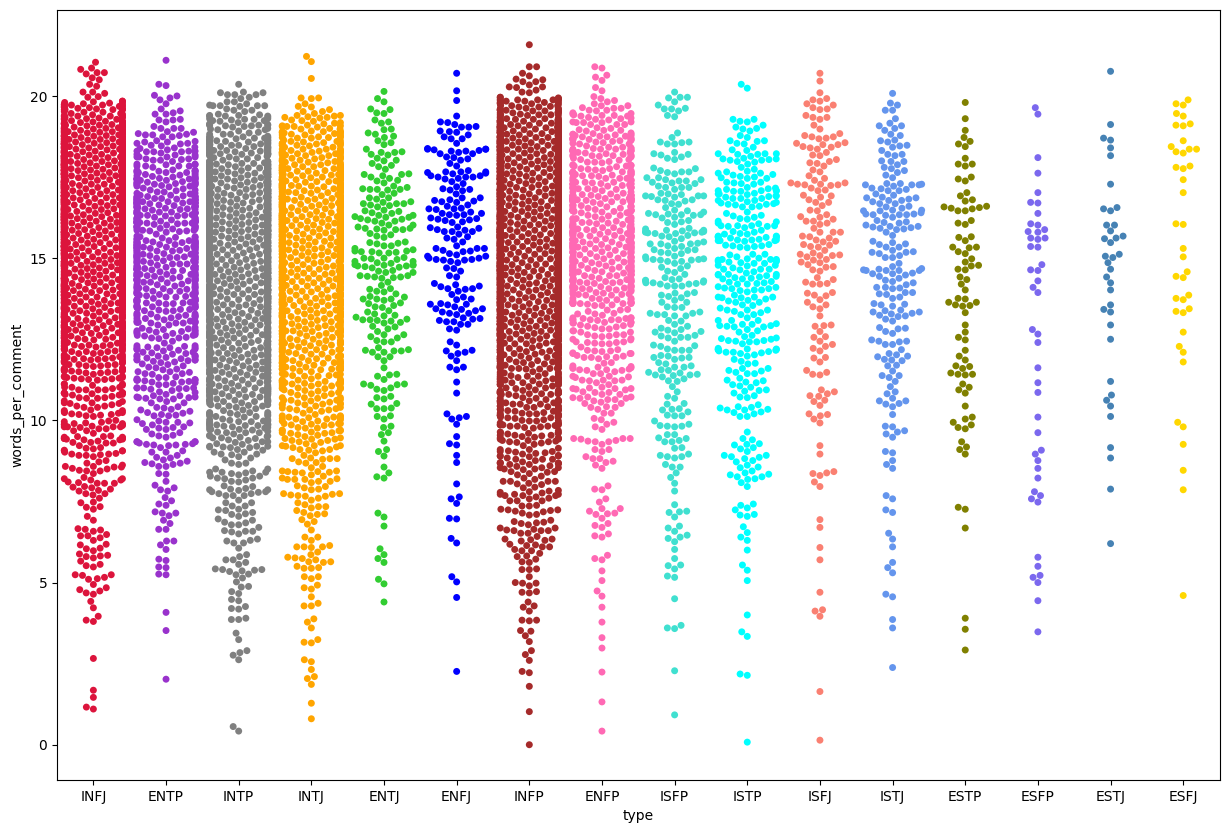

In [12]:
plt.figure(figsize=(15,10))
sns.swarmplot(data=sw, x="type", y="words_per_comment", palette = colors)
plt.show()

In [13]:
sw['E/I'] = sw['type'].apply(lambda x: x[0] == 'E').astype('int')
sw['S/N'] = sw['type'].apply(lambda x: x[1] == 'S').astype('int')
sw['T/F'] = sw['type'].apply(lambda x: x[2] == 'T').astype('int')
sw['J/P'] = sw['type'].apply(lambda x: x[3] == 'J').astype('int')
sw.head()

,type,posts,cleaned_posts,words_per_comment,E/I,S/N,T/F,J/P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank what ...,6.44,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,i finding lack post alarming sex boring posit...,14.10,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course i say i know blessing curse d...,10.14,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed conversation day esoteric...,12.46,0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,you fired that another silly misconception th...,11.40,1,0,1,1


Difference in post lengths before and after preprocessing.

In [14]:
print(len(sw['posts'][1000]), len(sw['cleaned_posts'][1000]))

8172 5122


In [15]:
nlp = spacy.load("en_core_web_sm")


In [16]:
def tfidf_vectorize(num_features):
    TFIDF_vect = TfidfVectorizer(stop_words='english', max_features=num_features)
    all_data_TFIDF = TFIDF_vect.fit_transform(sw['cleaned_posts'])
    return all_data_TFIDF

# Model Training Stage

In [17]:
def logistic_regression(X_vec, y, K, split_rate, featureSize):
    print("Training Logistic Regression with Params\nSplit Rate: ", split_rate, "- #Features: ", featureSize)
    
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=split_rate, random_state=42, stratify=y)
    selector = SelectKBest(chi2, k=featureSize)
    K_train = selector.fit_transform(X_train, y_train)
    K_test = selector.transform(X_test)
    
    params = {
        "split_rate": split_rate,
        "SCV_folds": K ,
        "FeatureNum": featureSize
    }
    
    with mlflow.start_run(run_name='Logistic Regression'):
        mlflow.log_params(params)
        logistic_regression_classifier = LogisticRegression()
        logistic_regression_classifier.fit(K_train, y_train)
        prediction_test = logistic_regression_classifier.predict(K_test)
        if(K > 0):
            skf = StratifiedKFold(n_splits=K)
            print('Cross Validation Accuracy:', round(cross_val_score(logistic_regression_classifier, K_train, y_train, cv=skf).mean(), 3))
        else:
            prediction_train = logistic_regression_classifier.predict(K_train)
            print('Train Accuracy:', round(accuracy_score(y_train, prediction_train), 3))
        accuracy = accuracy_score(y_test, prediction_test)
        f1Score = f1_score(y_test, prediction_test, average='weighted')
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("f1_score", f1Score)
        mlflow.sklearn.log_model(logistic_regression_classifier, "Logistic Regression")
        print('Test Accuracy:', round(accuracy, 3))        
        print("\n------------------------------------------------------------------")

In [18]:
def SVM(X_vec, y, K, split_rate, featureSize, kernelType, C_reg, gamma_rate):
    print("Training Support Vector Machine with Params:\nSplit Rate: ", split_rate, "- #Features: ", featureSize, "- kernel: ", kernelType, "- C_Value: ", C_reg, "- gamma: ", gamma_rate)

    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=split_rate, random_state=42, stratify=y)
    selector = SelectKBest(chi2, k=featureSize)
    K_train = selector.fit_transform(X_train, y_train)
    K_test = selector.transform(X_test)
    
    params = {
        "split_rate": split_rate,
        "SCV_folds": K ,
        "FeatureNum": featureSize,
        "kernel" : kernelType,
        "C" : C_reg,
        "Gamma": gamma_rate
    }
    
    with mlflow.start_run(run_name='Support Vector Machine'):
        mlflow.log_params(params)
        if(kernelType == "linear"):
            model_svc=SVC(C= C_reg, kernel=kernelType)
        else:
            model_svc=SVC(C= C_reg, kernel=kernelType, gamma=gamma_rate)
        model_svc.fit(K_train,y_train)
        prediction_test = model_svc.predict(K_test)
        if(K > 0):
            skf = StratifiedKFold(n_splits=K)
            print('Cross Validation Accuracy:', round(cross_val_score(model_svc, K_train, y_train, cv=skf).mean(), 3))
        else:
            prediction_train = model_svc.predict(K_train)
            print('Train Accuracy:', round(accuracy_score(y_train, prediction_train), 3))
            
        accuracy = accuracy_score(y_test, prediction_test)
        f1Score = f1_score(y_test, prediction_test, average='weighted')
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("f1_score", f1Score)
        mlflow.sklearn.log_model(model_svc, "Support Vector Machine")
        print('Test Accuracy:', round(accuracy, 3)) 
        print("\n------------------------------------------------------------------")

In [19]:
def naive_bayes(X_vec, y, K, split_rate, featureSize, alpha_value):
    print("Training Naive Bayes with Params:\nSplit Rate: ", split_rate, "- #Features: ", featureSize, "- alpha:", alpha_value)

    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=split_rate, random_state=42, stratify=y)
    selector = SelectKBest(chi2, k=featureSize)
    K_train = selector.fit_transform(X_train, y_train)
    K_test = selector.transform(X_test)
    
    params = {
        "split_rate": split_rate,
        "SCV_folds": K ,
        "FeatureNum": featureSize,
        "Alpha": alpha_value,
    }
    
    with mlflow.start_run(run_name='Naive Bayes'):
        mlflow.log_params(params)
        model_multinomial_nb=MultinomialNB(alpha = alpha_value)
        model_multinomial_nb.fit(X_train,y_train)
        prediction_test = model_multinomial_nb.predict(X_test)
        if(K > 0):
            skf = StratifiedKFold(n_splits=K)
            print('Cross Validation Accuracy:', round(cross_val_score(model_multinomial_nb, X_train, y_train, cv=skf).mean(), 3))
        else:
            prediction_train = model_multinomial_nb.predict(X_train)
            print('Train Accuracy:', round(accuracy_score(y_train, prediction_train), 3))
            
        accuracy = balanced_accuracy_score(y_test, prediction_test)
        f1Score = f1_score(y_test, prediction_test, average='weighted')
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("f1_score", f1Score)
        mlflow.sklearn.log_model(model_multinomial_nb, "Naive Bayes")
        print('Test Accuracy:', round(accuracy, 3)) 
        print("\n------------------------------------------------------------------")

In [20]:
def random_forest(X_vec, y, K, split_rate, featureSize, num_estimators, criteria, depth_max):
    print("Training Random Forest with Params:\nSplit Rate: ", split_rate, "- #Features: ", featureSize, "- #Estimators: ",  num_estimators, "-criteria: ", criteria, "- Max_Depth: ", depth_max)
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=split_rate, random_state=42, stratify=y)
    selector = SelectKBest(chi2, k=featureSize)
    K_train = selector.fit_transform(X_train, y_train)
    K_test = selector.transform(X_test)
    
    params = {
        "split_rate": split_rate,
        "SCV_folds": K ,
        "FeatureNum": featureSize,
        "n_estimators": num_estimators,
        "criterion": criteria,
        "depth_max": depth_max
    }
    with mlflow.start_run(run_name='Random Forest'):
        mlflow.log_params(params)
        model_forest=RandomForestClassifier(n_estimators = num_estimators, criterion = criteria, max_depth = depth_max)
        model_forest.fit(K_train,y_train)
        prediction_test = model_forest.predict(K_test)
        if(K > 0):
            skf = StratifiedKFold(n_splits=K)
            print('Cross Validation Accuracy:', round(cross_val_score(model_forest, K_train, y_train, cv=skf).mean(), 3))
        else:
            prediction_train = model_forest.predict(K_train)
            print('Train Accuracy:', round(accuracy_score(y_train, prediction_train), 3))
            
        accuracy = balanced_accuracy_score(y_test, prediction_test)
        f1Score = f1_score(y_test, prediction_test, average='weighted')
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("f1_score", f1Score)
        mlflow.sklearn.log_model(RandomForestClassifier, "Random Forest")
        print('Test Accuracy:', round(accuracy, 3)) 
        print("\n------------------------------------------------------------------")

In [21]:
def xgboost(X_vec, y, K, split_rate, featureSize, learn_rate, num_estimators, depth_max):
    print("Training XGBoost with Params:\nSplit Rate: ", split_rate, "- #Features: ", featureSize, "- #Estimators: ", num_estimators, "- learning_rate: ", learn_rate, "- Max_Depth: ", depth_max)
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=split_rate, random_state=42, stratify=y)
    selector = SelectKBest(chi2, k=featureSize)
    K_train = selector.fit_transform(X_train, y_train)
    K_test = selector.transform(X_test)
    
    params = {
        "split_rate": split_rate,
        "SCV_folds": K ,
        "FeatureNum": featureSize,
        "Learning_Rate": learn_rate,
        "n_estimators": num_estimators,
        "depth_max": depth_max,
    }
    
    with mlflow.start_run(run_name='XGBoost'):
        mlflow.log_params(params)
        model_xgb=XGBClassifier(tree_method='gpu_hist', n_estimators=num_estimators, max_depth=depth_max, eta=learn_rate)
        model_xgb.fit(K_train,y_train)
        prediction_test = model_xgb.predict(K_test)
        if(K > 0):
            skf = StratifiedKFold(n_splits=K)
            print('Cross Validation Accuracy:', round(cross_val_score(model_xgb, K_train, y_train, cv=skf).mean(), 3))
        else:
            prediction_train = model_xgb.predict(K_train)
            print('Train Accuracy:', round(accuracy_score(y_train, prediction_train), 3))
            
        accuracy = accuracy_score(y_test, prediction_test)
        f1Score = f1_score(y_test, prediction_test, average='weighted')
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("f1_score", f1Score)
        mlflow.sklearn.log_model(model_xgb, "XGBoost")
        print('Test Accuracy:', round(accuracy, 3))
        print("\n------------------------------------------------------------------")

In [22]:
def catBoost(X_vec, y, K, split_rate, featureSize, learn_rate, depth_max, epoch):
    print("Training catBoost with Params:\nSplit Rate: ", split_rate, "- #Features: ", featureSize, "- learning_rate: ", learn_rate, "- Max_Depth: ", depth_max, "- #Iterations: ", epoch)
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=split_rate, random_state=42, stratify=y)
    selector = SelectKBest(chi2, k=featureSize)
    K_train = selector.fit_transform(X_train, y_train)
    K_test = selector.transform(X_test)
    
    params = {
        "split_rate": split_rate,
        "SCV_folds": K ,
        "FeatureNum": featureSize,
        "Learning_Rate": learn_rate,
        "depth_max": depth_max,
        "iterations": epoch
    }
    with mlflow.start_run(run_name='catBoost'):
        mlflow.log_params(params)
        model_cat=CatBoostClassifier(iterations=epoch, max_depth=depth_max, learning_rate=learn_rate, loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU', verbose=False)
        model_cat.fit(K_train,y_train)
        prediction_test = model_cat.predict(K_test)

        if(K > 0):
            skf = StratifiedKFold(n_splits=K)
            print('Cross Validation Accuracy:', round(cross_val_score(model_cat, K_train, y_train, cv=skf).mean(), 3))
        else:
            prediction_train = model_cat.predict(K_train)
            print('Train Accuracy:', round(accuracy_score(y_train, prediction_train), 3))
            
        accuracy = accuracy_score(y_test, prediction_test)
        f1Score = f1_score(y_test, prediction_test, average='weighted')
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("f1_score", f1Score)
        mlflow.sklearn.log_model(CatBoostClassifier, "catBoost")
        print('Test Accuracy:', round(accuracy, 3))


# Hyper-Parameter Tuning Stage

In [23]:
def hyper_logistic_regression(X, y):
    logistic_regression(X, y, 3, 0.2, 1000)
    logistic_regression(X, y, 3, 0.3, 1000)
    logistic_regression(X, y, 3, 0.4, 1000)
    logistic_regression(X, y, 3, 0.2, 1000)
    logistic_regression(X, y, 3, 0.2, 500)
    logistic_regression(X, y, 3, 0.2, 2000)
    logistic_regression(X, y, 3, 0.2, 5000)


In [24]:
def hyper_SVM(X, y):
    SVM(X, y, 3, 0.2, 1000, 'linear', 1, 0)
    SVM(X, y, 3, 0.4, 1000, 'linear', 1, 0)
    SVM(X, y, 3, 0.2, 2500, 'linear', 1, 0)
    SVM(X, y, 3, 0.2, 500, 'linear', 1, 0)
    SVM(X, y, 3, 0.2, 1000, 'linear', 1, 0)
    SVM(X, y, 3, 0.2, 1000, 'linear', 10, 0)
    SVM(X, y, 3, 0.2, 1000, 'linear', 100, 0)
    SVM(X, y, 3, 0.2, 1000, 'poly', 1, 0.01)
    SVM(X, y, 3, 0.2, 1000, 'rbf', 1, 0.01)
    SVM(X, y, 3, 0.2, 1000, 'sigmoid', 1, 0.01)
    SVM(X, y, 3, 0.2, 1000, 'sigmoid', 1, 0.5)
    SVM(X, y, 3, 0.2, 1000, 'sigmoid', 1, 2)
   

In [25]:
def hyper_naive_bayes(X, y):
    naive_bayes(X, y, 3,  0.2, 1000, 1)
    naive_bayes(X, y, 3,  0.4, 1000, 1)
    naive_bayes(X, y, 3,  0.2, 500, 1)
    naive_bayes(X, y, 3,  0.2, 2000, 1)
    naive_bayes(X, y, 3,  0.2, 1000, 10)
    naive_bayes(X, y, 3,  0.2, 1000, 100)



In [26]:
def hyper_random_forest(X, y):
    random_forest(X, y, 3, 0.2, 1000, 100, 'gini', 10)
    random_forest(X, y, 3, 0.4, 1000, 100, 'gini', 10)
    random_forest(X, y, 3, 0.2, 2500, 100, 'gini', 10)
    random_forest(X, y, 3, 0.2, 500, 100, 'gini', 10)
    random_forest(X, y, 3, 0.2, 1000, 100, 'entropy', 10)
    random_forest(X, y, 3, 0.2, 1000, 100, 'log_loss', 10)
    random_forest(X, y, 3, 0.2, 1000, 10, 'gini', 10)
    random_forest(X, y, 3, 0.2, 1000, 50, 'gini', 10)
    random_forest(X, y, 3, 0.2, 1000, 50, 'gini', 5)



In [27]:
def hyper_xgboost(X, y):
    xgboost(X, y, 3, 0.2, 1000, 0.1, 100, 9)
    xgboost(X, y, 3, 0.4, 1000, 0.1, 100, 9)
    xgboost(X, y, 3, 0.2, 2500, 0.1, 100, 3)
    xgboost(X, y, 3, 0.2, 5000, 0.1, 100, 3)
    xgboost(X, y, 3, 0.2, 1000, 0.1, 200, 6)
    xgboost(X, y, 3, 0.2, 1000, 1, 100, 6)


In [28]:
def hyper_catBoost(X, y):
    catBoost(X, y, 3, 0.2, 1000, 0.1, 5, 200)
    catBoost(X, y, 3, 0.2, 3000, 0.1, 3, 200)
    catBoost(X, y, 3, 0.2, 1000, 0.5, 5, 200)
    catBoost(X, y, 3, 0.2, 1000, 0.5, 5, 500)
    catBoost(X, y, 3, 0.2, 1000, 0.1, 3, 1000)


In [29]:
def tune_model(model):

    X = tfidf_vectorize(100000)
    y = sw[['type']]
    target_encoder=LabelEncoder()
    y=target_encoder.fit_transform(y)

    if(model == "Logistic_Regression"):
        hyper_logistic_regression(X, y)
    elif(model == "SVM"):
        hyper_SVM(X, y)
    elif(model == "Naive_Bayes"):
        hyper_naive_bayes(X, y)
    elif(model == "Random_Forest"):
        hyper_random_forest(X, y)
    elif(model == "XGBoost"):
        hyper_xgboost(X, y)
    elif(model == "catBoost"):
        hyper_catBoost(X, y)

In [51]:
%%time
tune_model("Logistic_Regression")

Training Logistic Regression with Params
Split Rate:  0.2 - #Features:  1000
Cross Validation Accuracy: 0.579
Test Accuracy: 0.59

------------------------------------------------------------------
Training Logistic Regression with Params
Split Rate:  0.3 - #Features:  1000
Cross Validation Accuracy: 0.572
Test Accuracy: 0.576

------------------------------------------------------------------
Training Logistic Regression with Params
Split Rate:  0.4 - #Features:  1000
Cross Validation Accuracy: 0.561
Test Accuracy: 0.579

------------------------------------------------------------------
Training Logistic Regression with Params
Split Rate:  0.2 - #Features:  1000
Cross Validation Accuracy: 0.579
Test Accuracy: 0.59

------------------------------------------------------------------
Training Logistic Regression with Params
Split Rate:  0.2 - #Features:  500
Cross Validation Accuracy: 0.576
Test Accuracy: 0.587

------------------------------------------------------------------
Training

In [52]:
%%time
tune_model("SVM")

Training Support Vector Machine with Params:
Split Rate:  0.2 - #Features:  1000 - kernel:  linear - C_Value:  1 - gamma:  0
Cross Validation Accuracy: 0.566
Test Accuracy: 0.588

------------------------------------------------------------------
Training Support Vector Machine with Params:
Split Rate:  0.4 - #Features:  1000 - kernel:  linear - C_Value:  1 - gamma:  0
Cross Validation Accuracy: 0.536
Test Accuracy: 0.573

------------------------------------------------------------------
Training Support Vector Machine with Params:
Split Rate:  0.2 - #Features:  2500 - kernel:  linear - C_Value:  1 - gamma:  0
Cross Validation Accuracy: 0.586
Test Accuracy: 0.603

------------------------------------------------------------------
Training Support Vector Machine with Params:
Split Rate:  0.2 - #Features:  500 - kernel:  linear - C_Value:  1 - gamma:  0
Cross Validation Accuracy: 0.563
Test Accuracy: 0.591

------------------------------------------------------------------
Training Supp

In [53]:
%%time
tune_model("Naive_Bayes")

Training Naive Bayes with Params:
Split Rate:  0.2 - #Features:  1000 - alpha: 1
Cross Validation Accuracy: 0.212
Test Accuracy: 0.063

------------------------------------------------------------------
Training Naive Bayes with Params:
Split Rate:  0.4 - #Features:  1000 - alpha: 1
Cross Validation Accuracy: 0.212
Test Accuracy: 0.063

------------------------------------------------------------------
Training Naive Bayes with Params:
Split Rate:  0.2 - #Features:  500 - alpha: 1
Cross Validation Accuracy: 0.212
Test Accuracy: 0.063

------------------------------------------------------------------
Training Naive Bayes with Params:
Split Rate:  0.2 - #Features:  2000 - alpha: 1
Cross Validation Accuracy: 0.212
Test Accuracy: 0.063

------------------------------------------------------------------
Training Naive Bayes with Params:
Split Rate:  0.2 - #Features:  1000 - alpha: 10
Cross Validation Accuracy: 0.211
Test Accuracy: 0.062

----------------------------------------------------

In [54]:
%%time
tune_model("Random_Forest")

Training Random Forest with Params:
Split Rate:  0.2 - #Features:  1000 - #Estimators:  100 -criteria:  gini - Max_Depth:  10
Cross Validation Accuracy: 0.523
Test Accuracy: 0.256

------------------------------------------------------------------
Training Random Forest with Params:
Split Rate:  0.4 - #Features:  1000 - #Estimators:  100 -criteria:  gini - Max_Depth:  10
Cross Validation Accuracy: 0.538
Test Accuracy: 0.246

------------------------------------------------------------------
Training Random Forest with Params:
Split Rate:  0.2 - #Features:  2500 - #Estimators:  100 -criteria:  gini - Max_Depth:  10
Cross Validation Accuracy: 0.489
Test Accuracy: 0.206

------------------------------------------------------------------
Training Random Forest with Params:
Split Rate:  0.2 - #Features:  500 - #Estimators:  100 -criteria:  gini - Max_Depth:  10
Cross Validation Accuracy: 0.57
Test Accuracy: 0.278

------------------------------------------------------------------
Training R

In [55]:
%%time
tune_model("XGBoost")

Training XGBoost with Params:
Split Rate:  0.2 - #Features:  1000 - #Estimators:  100 - learning_rate:  0.1 - Max_Depth:  9
Cross Validation Accuracy: 0.458
Test Accuracy: 0.286

------------------------------------------------------------------
Training XGBoost with Params:
Split Rate:  0.4 - #Features:  1000 - #Estimators:  100 - learning_rate:  0.1 - Max_Depth:  9
Cross Validation Accuracy: 0.462
Test Accuracy: 0.411

------------------------------------------------------------------
Training XGBoost with Params:
Split Rate:  0.2 - #Features:  2500 - #Estimators:  100 - learning_rate:  0.1 - Max_Depth:  3
Cross Validation Accuracy: 0.456
Test Accuracy: 0.451

------------------------------------------------------------------
Training XGBoost with Params:
Split Rate:  0.2 - #Features:  5000 - #Estimators:  100 - learning_rate:  0.1 - Max_Depth:  3
Cross Validation Accuracy: 0.471
Test Accuracy: 0.478

------------------------------------------------------------------
Training XGBoost

In [56]:
%%time
tune_model("catBoost")

Training catBoost with Params:
Split Rate:  0.2 - #Features:  1000 - learning_rate:  0.1 - Max_Depth:  5 - #Iterations:  200
Cross Validation Accuracy: 0.65
Test Accuracy: 0.648
Training catBoost with Params:
Split Rate:  0.2 - #Features:  3000 - learning_rate:  0.1 - Max_Depth:  3 - #Iterations:  200
Cross Validation Accuracy: 0.649
Test Accuracy: 0.644
Training catBoost with Params:
Split Rate:  0.2 - #Features:  1000 - learning_rate:  0.5 - Max_Depth:  5 - #Iterations:  200
Cross Validation Accuracy: 0.636
Test Accuracy: 0.628
Training catBoost with Params:
Split Rate:  0.2 - #Features:  1000 - learning_rate:  0.5 - Max_Depth:  5 - #Iterations:  500
Cross Validation Accuracy: 0.642
Test Accuracy: 0.637
Training catBoost with Params:
Split Rate:  0.2 - #Features:  1000 - learning_rate:  0.1 - Max_Depth:  3 - #Iterations:  1000
Cross Validation Accuracy: 0.659
Test Accuracy: 0.658
CPU times: total: 6min 54s
Wall time: 4min 12s


Our attempt at doing a grid search for best parameters for XGBoost, but there were many exceptions when we used more than one cpu core, therefore GridSearch took too long and drove the computer to crash. 

In [57]:
# def GRIDSEARCH():
#     y = sw[['type']]
#     X = sw['cleaned_posts']
#     target_encoder = LabelEncoder()
#     y = target_encoder.fit_transform(y)
#     model_pipeline = Pipeline([
#         ('tfidf', TfidfVectorizer(stop_words='english', max_features=100000)),
#         ('kbest', SelectKBest(chi2, k = 2000)),
#         ('XGBoost', XGBClassifier(tree_method='gpu_hist', n_estimators=200, max_depth=5, learning_rate=0.1) )
#     ])
    
#     param_grid = {
#     'tfidf__max_features': [50000, 100000],
#     'kbest__k': [1000, 2000, 5000, 10000],
#     'XGBoost__n_estimators': [100, 200, 500],
#     'XGBoost__max_depth': [3, 5, 7],
#     'XGBoost__learning_rate': [0.1, 0.4, 0.7]
#     }
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#     model_grid = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=1)
#     model_grid.fit(X_train, y_train)

#     print(model_grid.best_params_)



This method was originally created to integrate best parameters of grid search into the pipeline however our computers can not complete the algorithm without crashing.

In [58]:
def create_best_pipeline():
    y = sw[['type']]
    X = sw['cleaned_posts']
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y)
    model_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=50000)),
        ('kbest', SelectKBest(chi2, k = 2000)),
        ('XGBoost', XGBClassifier(tree_method='gpu_hist', n_estimators=200, max_depth=5, learning_rate=0.1) )
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_test)
    print("PIPELINE ACCURACY", round(accuracy_score(y_test, predictions), 3))
    with open("XGboost_pipeline.pkl", mode = "wb"):
        joblib.dump(model_pipeline, "XGboost_pipeline.pkl")


In [59]:
#GRIDSEARCH()
create_best_pipeline()

PIPELINE ACCURACY 0.492


In [ ]:
!mlflow ui